<a href="https://colab.research.google.com/github/SaurabhNitz/Illegal-Fishing-Detection-using-InceptionTime-Model/blob/main/illegal_fishing_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries & dependencies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime, timedelta

In [2]:
TIME_STEP_INTERVAL = timedelta(hours=1)

In [3]:
import time
import os
from typing import Dict, Iterable

In [5]:
def to_unix_time(timestamp: datetime) -> int:
    return time.mktime(timestamp.timetuple())

def with_fixed_time_steps(input_data: Dict[str, np.ndarray]) -> pd.DataFrame:
    return (
        pd.DataFrame(input_data)
        .assign(timestamp=lambda df: df["timestamp"].map(datetime.utcfromtimestamp))
        .resample(TIME_STEP_INTERVAL, on="timestamp")
        .mean()
        .reset_index()
        .assign(timestamp=lambda df: df["timestamp"].map(to_unix_time))
        .interpolate()
    )

In [6]:
def read_labels(labels_file: str) -> pd.DataFrame:
    with tf.io.gfile.GFile(labels_file, "r") as f:
        return (
            pd.read_csv(f, parse_dates=["start_time", "end_time"])
            .assign(
                start_time=lambda df: df["start_time"].map(to_unix_time),
                end_time=lambda df: df["end_time"].map(to_unix_time),
            )
        )

In [7]:
def read_data(data_file: str) -> pd.DataFrame:
    mmsi = os.path.splitext(os.path.basename(data_file))[0]
    with tf.io.gfile.GFile(data_file, "rb") as f:
        return with_fixed_time_steps(np.load(f)["x"]).assign(
            mmsi=lambda df: df["mmsi"].map(lambda _: int(mmsi)),
        )

In [8]:
def label_data(data: pd.DataFrame, labels: pd.DataFrame) -> pd.DataFrame:
    data_with_labels = (
        pd.merge_asof(
            left=data,
            right=labels,
            left_on="timestamp",
            right_on="start_time",
            by="mmsi",
        )
        .query("timestamp <= end_time")
        .drop(columns=["start_time", "end_time"])
    )

    labeled_data = data.assign(is_fishing=lambda _: np.nan)
    labeled_data.update(data_with_labels)
    return labeled_data.sort_values(by=['timestamp']).drop(
        columns=["mmsi","distance_from_shore"]
    )

In [9]:
def generate_training_points(data: pd.DataFrame):
    # Pandas assigns NaN (Not-a-Number) if a value is missing.
    # If is_fishing equals itself it means it's populated because (NaN != NaN).
    # For the training data points, we only get points where we have a label.
    padding = 24
    training_point_indices = (
        data[padding:].query("is_fishing == is_fishing").index.tolist()
    )
    while True:
        for point_index in training_point_indices:
            inputs = (
                data.drop(columns=["is_fishing"])
                .loc[point_index - padding : point_index]
                .to_dict("list")
            )
            outputs = (
                data[["is_fishing"]]
                .loc[point_index:point_index]
                .astype("int8")
                .to_dict("list")
            )
            #note: if you have python>3.9 then use the line below instead
            data_point = {**outputs, **inputs}
            #data_point = outputs | inputs

            yield data_point

Pre-Processing of data

In [11]:
data = read_data("175387414441613.npz")

In [12]:
data = data[["mmsi","timestamp","distance_from_shore","distance_from_port","speed","course","lat","lon"]]

In [13]:
data.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon
0,175387414441613,1.325437e+09,0.000000,999.975464,0.000000,201.699997,62.117252,-6.725497
1,175387414441613,1.325441e+09,2794.744466,4158.785290,0.026042,203.224997,62.099120,-6.710331
2,175387414441613,1.325444e+09,5589.488932,7317.595116,0.052083,204.749997,62.080987,-6.695165
3,175387414441613,1.325448e+09,8384.233398,10476.404942,0.078125,206.274997,62.062855,-6.679999
4,175387414441613,1.325452e+09,11178.977865,13635.214767,0.104167,207.799997,62.044722,-6.664834


In [14]:
data.tail()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon
42938,175387414441613,1.480014e+09,19697.232422,30674.970703,12.60,228.800003,61.597534,-6.538116
42939,175387414441613,1.480018e+09,14772.924316,23256.221893,9.45,190.875002,61.586372,-6.605085
42940,175387414441613,1.480021e+09,9848.616211,15837.473083,6.30,152.950001,61.575211,-6.672054
42941,175387414441613,1.480025e+09,4924.308105,8418.724274,3.15,115.025000,61.564049,-6.739023
42942,175387414441613,1.480028e+09,0.000000,999.975464,0.00,77.099998,61.552887,-6.805992


In [15]:
labels = read_labels("kristina_trawl.csv")

In [17]:
labels.head()

,mmsi,start_time,end_time,is_fishing
0,175387414441613,1.293840e+09,1.293841e+09,1.0
1,175387414441613,1.293851e+09,1.293852e+09,1.0
2,175387414441613,1.293857e+09,1.293859e+09,1.0
3,175387414441613,1.293863e+09,1.293864e+09,1.0
4,175387414441613,1.293869e+09,1.293870e+09,1.0


In [18]:
labels.tail()

,mmsi,start_time,end_time,is_fishing
55965,222656062190286,1.438467e+09,1.438474e+09,0.0
55966,222656062190286,1.438482e+09,1.438483e+09,0.0
55967,222656062190286,1.438488e+09,1.438489e+09,0.0
55968,222656062190286,1.438511e+09,1.438514e+09,0.0
55969,222656062190286,1.438518e+09,1.438526e+09,0.0


In [19]:
labels = labels[labels.mmsi == 175387414441613]

In [20]:
data = label_data(data,labels)

In [21]:
data = data[~data['is_fishing'].isna()]

In [22]:
data.head()

,timestamp,distance_from_port,speed,course,lat,lon,is_fishing
85,1.325743e+09,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
93,1.325772e+09,294769.289272,2.421875,343.525006,60.430931,-5.315076,1.0
96,1.325783e+09,304245.718750,2.500000,348.100006,60.376534,-5.269578,1.0
104,1.325812e+09,306889.402525,2.473510,336.091176,60.354940,-5.312330,1.0
127,1.325894e+09,314489.993377,2.397351,301.565789,60.292858,-5.435242,1.0


In [23]:
data.tail()

,timestamp,distance_from_port,speed,course,lat,lon,is_fishing
32801,1.443521e+09,320348.863281,6.4750,181.649998,63.408834,-5.420086,0.0
32807,1.443542e+09,164145.296875,3.1000,207.000000,62.662319,-5.436085,0.0
32808,1.443546e+09,160557.562500,4.0000,279.000000,62.656818,-5.464962,0.0
32810,1.443553e+09,123536.553711,6.6125,252.274996,62.589118,-5.784683,0.0
32818,1.443582e+09,999.975464,0.0000,306.200012,61.552808,-6.806088,0.0


In [24]:
from datetime import datetime, timedelta
import datetime
import os
import time
from typing import Dict, Iterable

In [25]:
def read_timestamp(timestamp):
    timestamp = datetime.datetime.fromtimestamp(timestamp)
    return print(timestamp.strftime('%Y-%m-%d %H:%M:%S'))

In [26]:
read_timestamp(1.325761e+09)
data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

2012-01-05 10:56:40


In [27]:
data.head()

,timestamp,distance_from_port,speed,course,lat,lon,is_fishing
85,2012-01-05 06:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
93,2012-01-05 14:00:00,294769.289272,2.421875,343.525006,60.430931,-5.315076,1.0
96,2012-01-05 17:00:00,304245.718750,2.500000,348.100006,60.376534,-5.269578,1.0
104,2012-01-06 01:00:00,306889.402525,2.473510,336.091176,60.354940,-5.312330,1.0
127,2012-01-07 00:00:00,314489.993377,2.397351,301.565789,60.292858,-5.435242,1.0


In [28]:
data.tail()

,timestamp,distance_from_port,speed,course,lat,lon,is_fishing
32801,2015-09-29 10:00:00,320348.863281,6.4750,181.649998,63.408834,-5.420086,0.0
32807,2015-09-29 16:00:00,164145.296875,3.1000,207.000000,62.662319,-5.436085,0.0
32808,2015-09-29 17:00:00,160557.562500,4.0000,279.000000,62.656818,-5.464962,0.0
32810,2015-09-29 19:00:00,123536.553711,6.6125,252.274996,62.589118,-5.784683,0.0
32818,2015-09-30 03:00:00,999.975464,0.0000,306.200012,61.552808,-6.806088,0.0


In [29]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [30]:
data.set_index('timestamp', inplace=True)

In [31]:
data = data.resample('60min').mean()

In [32]:
data = data.interpolate(method='nearest')

In [33]:
data.reset_index(level=0, inplace=True)

In [34]:
data.shape

(32734, 7)

In [35]:
data.head()

,timestamp,distance_from_port,speed,course,lat,lon,is_fishing
0,2012-01-05 06:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
1,2012-01-05 07:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
2,2012-01-05 08:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
3,2012-01-05 09:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
4,2012-01-05 10:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0


In [36]:
data.tail()

,timestamp,distance_from_port,speed,course,lat,lon,is_fishing
32729,2015-09-29 23:00:00,123536.553711,6.6125,252.274996,62.589118,-5.784683,0.0
32730,2015-09-30 00:00:00,999.975464,0.0000,306.200012,61.552808,-6.806088,0.0
32731,2015-09-30 01:00:00,999.975464,0.0000,306.200012,61.552808,-6.806088,0.0
32732,2015-09-30 02:00:00,999.975464,0.0000,306.200012,61.552808,-6.806088,0.0
32733,2015-09-30 03:00:00,999.975464,0.0000,306.200012,61.552808,-6.806088,0.0


In [37]:
data.drop("timestamp", axis=1, inplace=True)

In [38]:
data.head()

,distance_from_port,speed,course,lat,lon,is_fishing
0,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
1,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
2,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
3,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
4,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0


In [39]:
data.tail()

,distance_from_port,speed,course,lat,lon,is_fishing
32729,123536.553711,6.6125,252.274996,62.589118,-5.784683,0.0
32730,999.975464,0.0000,306.200012,61.552808,-6.806088,0.0
32731,999.975464,0.0000,306.200012,61.552808,-6.806088,0.0
32732,999.975464,0.0000,306.200012,61.552808,-6.806088,0.0
32733,999.975464,0.0000,306.200012,61.552808,-6.806088,0.0


In [40]:
n = data.groupby(['is_fishing']).size()
print(n)

is_fishing
0.0    23571
1.0     9163
dtype: int64


In [41]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

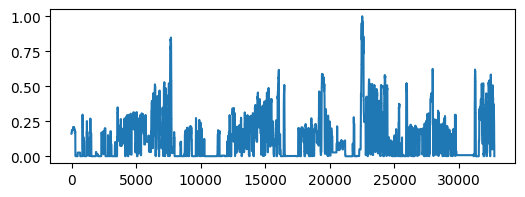

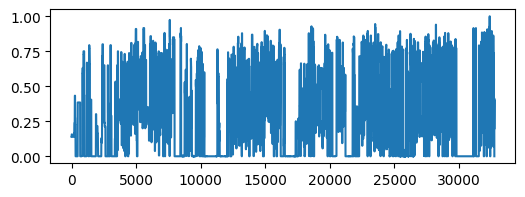

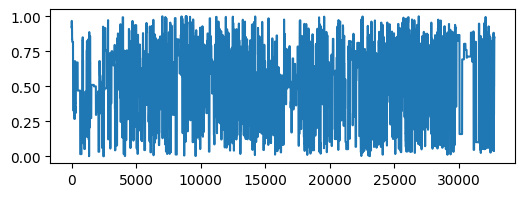

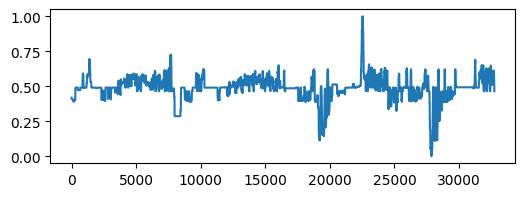

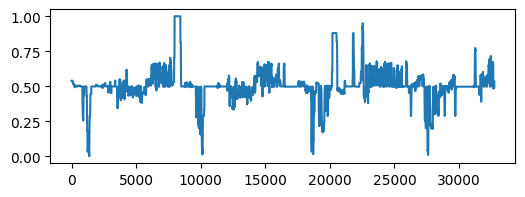

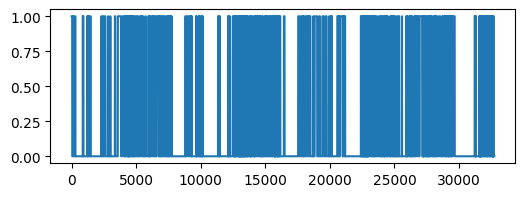

In [42]:
for i in range(data.iloc[0,:].shape[0]):
    plt.figure(figsize=(6,2))
    plt.plot(NormalizeData(data.iloc[:,i]))
    plt.show()

In [43]:
def batch_generator(generator, batch_size,ts_len=25,features=5):
    batch_features = np.zeros((batch_size,ts_len, features))
    batch_labels = np.zeros((batch_size,1))

    while True:
        for i in range(batch_size):
            data = next(generator)
            for j, k in enumerate(data.keys()):
                data_arr = np.asarray(data[k])
                if j == 0:
                    batch_labels[i] = data_arr
                else:
                    batch_features[i,:,j-1] = data_arr

        yield batch_features, batch_labels

In [44]:
def _inception_module(input_tensor, stride=1, activation='linear', use_bottleneck=True, kernel_size=40, bottleneck_size=32, nb_filters=32):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1,
                                              padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i],
                                              strides=stride, padding='same', activation=activation, use_bias=False)(
            input_inception))

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

    conv_6 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=1,
                                  padding='same', activation=activation, use_bias=False)(max_pool_1)

    conv_list.append(conv_6)

    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    return x

def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                      padding='same', use_bias=False)(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def build_model(input_shape, nb_classes, depth=8, use_residual=True):
    input_layer = tf.keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    output_layer = tf.keras.layers.Dense(units=nb_classes,activation='sigmoid')(gap_layer)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), metrics=[tf.keras.metrics.AUC(curve='ROC',name="AUROC"),tf.keras.metrics.AUC(curve='PR',name="AUPRC"),tf.keras.metrics.BinaryAccuracy()])

    return model

In [45]:
train_size = 0.8
valid_size=0.1

train_index = int(len(data)*train_size)

train_data = data[0:train_index]
df_rem = data[train_index:]

valid_index = int(len(data)*valid_size)

val_data = data[train_index:train_index+valid_index]
test_data = data[train_index+valid_index:]

In [46]:
train_data.shape, val_data, test_data

((26187, 6),
        distance_from_port     speed      course        lat       lon  \
 26187       331293.333333  3.650000  142.558330  60.107925 -7.752290   
 26188       330499.975000  3.620000  147.259996  60.113398 -7.763720   
 26189       329706.616667  3.590000  151.961662  60.118871 -7.775151   
 26190       329706.616667  3.590000  151.961662  60.118871 -7.775151   
 26191       329706.616667  3.590000  151.961662  60.118871 -7.775151   
 ...                   ...       ...         ...        ...       ...   
 29455       259128.281250  4.400000   61.150000  60.411150 -6.596543   
 29456       256019.927083  3.666667   50.850000  60.445476 -6.132655   
 29457       256019.927083  3.666667   50.850000  60.445476 -6.132655   
 29458       256019.927083  3.666667   50.850000  60.445476 -6.132655   
 29459       256019.927083  3.666667   50.850000  60.445476 -6.132655   
 
        is_fishing  
 26187         1.0  
 26188         1.0  
 26189         0.0  
 26190         0.0  
 261

In [47]:
batchsize = 32
epoch = 100

print("Training model...")

model = build_model((25,5), 1,depth=2)
history = model.fit(x=batch_generator(generate_training_points(train_data), batch_size = batchsize), epochs=epoch,
          steps_per_epoch=(len(train_data)//batchsize-1),
          validation_data=batch_generator(generate_training_points(val_data),batch_size = batchsize),
          validation_freq=1, validation_steps = (len(val_data)/batchsize-1))

Training model...
Epoch 1/100
817/817 [==============================] - 96s 115ms/step - loss: 0.8952 - AUROC: 0.5419 - AUPRC: 0.2907 - binary_accuracy: 0.2962 - val_loss: 0.9295 - val_AUROC: 0.3866 - val_AUPRC: 0.3639 - val_binary_accuracy: 0.4118
Epoch 2/100
817/817 [==============================] - 95s 116ms/step - loss: 0.8622 - AUROC: 0.5743 - AUPRC: 0.3019 - binary_accuracy: 0.3154 - val_loss: 0.8215 - val_AUROC: 0.5943 - val_AUPRC: 0.4829 - val_binary_accuracy: 0.4072
Epoch 3/100
817/817 [==============================] - 103s 126ms/step - loss: 0.8325 - AUROC: 0.6046 - AUPRC: 0.3231 - binary_accuracy: 0.3237 - val_loss: 0.7543 - val_AUROC: 0.7196 - val_AUPRC: 0.5663 - val_binary_accuracy: 0.4093
Epoch 4/100
817/817 [==============================] - 94s 116ms/step - loss: 0.8119 - AUROC: 0.5878 - AUPRC: 0.3142 - binary_accuracy: 0.3410 - val_loss: 0.7049 - val_AUROC: 0.7599 - val_AUPRC: 0.5771 - val_binary_accuracy: 0.4400
Epoch 5/100
817/817 [==============================] 

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 5)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 25, 32)               160       ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 25, 5)                0         ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 25, 32)               40960     ['conv1d[0][0]']          

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [50]:
ts_len = 25
channels = 5
features = np.zeros((len(test_data)-25,ts_len, channels))
labels = np.zeros((len(test_data)-25,1))
test_data_gen = generate_training_points(test_data)
for i in tqdm(range(len(test_data)-25)):
    d = next(test_data_gen)
    for j, k in enumerate(d.keys()):
        data_arr = np.asarray(d[k])
        if j == 0:
            labels[i] = data_arr
        else:
            features[i,:,j-1] = data_arr

100%|██████████| 3249/3249 [00:06<00:00, 489.17it/s]


In [51]:
pred = model.predict(features)

102/102 [==============================] - 1s 8ms/step


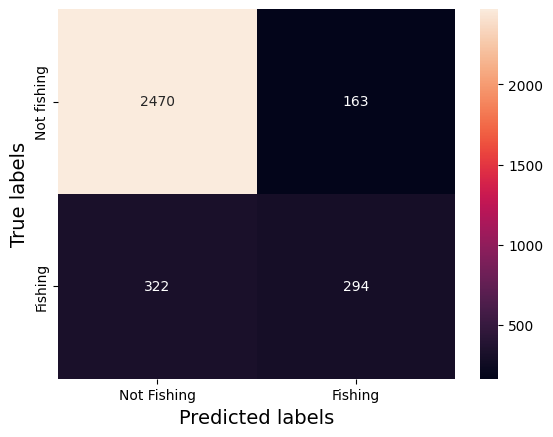

In [52]:
sns.heatmap(confusion_matrix(labels.ravel(),((pred>0.5)*1).ravel()), annot=True,fmt='g', xticklabels=["Not Fishing","Fishing"],yticklabels=["Not fishing","Fishing"])
#plt.xticks([0,1],["Fishing","Not fishing"])

plt.ylabel("True labels",fontsize=14)
plt.xlabel("Predicted labels",fontsize=14)
plt.show()

In [53]:
test_data_labels = test_data['is_fishing'].copy()

In [54]:
features_label = tf.convert_to_tensor(features, np.float32)
test_data_labels = test_data_labels.to_numpy()
print(type(test_data_labels))
test_data_labels = tf.convert_to_tensor(test_data_labels)
print(type(test_data_labels))

<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [55]:
print(type(features_label))
print(type(test_data_labels))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [56]:
# Generate generalization metrics
score = model.evaluate(features_label, test_data_labels[:3249], verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.39171263575553894 / Test accuracy: 0.8513085246086121


In [57]:
!pip install pyyaml h5py

In [58]:
from tensorflow.keras.models import load_model

In [59]:
model.save('/content/drive/MyDrive/ML Models/Inception_Model.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [60]:
model.save('/content/drive/MyDrive/ML Models/Inception_Model.h5')

In [63]:
from google.colab import files
files.download('/content/drive/MyDrive/ML Models/Inception_Model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>